In [1]:
RUN_PYTHON_SCRIPT = False

False

In [2]:

from jin_utils import get_mypkg_path
import sys
mypkg = get_mypkg_path()
sys.path.append(mypkg)

from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [3]:
import numpy as np
import numpy.random as npr
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
from tqdm import trange, tqdm
from joblib import Parallel, delayed
import time

plt.style.use(FIG_ROOT/"base.mplstyle")
%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [5]:
from utils.reparam import ThetaTransform
from spectrome import Brain
from sgm.sgm import SGM
from utils.misc import save_pkl, save_pkl_dict2folder, load_pkl, load_pkl_folder2dict, delta_time
from utils.misc import get_cpt_ts
from utils.stable import paras_stable_check
from models.gpt import myNet
from models.model_utils import generate_position_encode
from models.loss import  weighted_mse_loss, reg_R_loss, lin_R_loss, lin_R_fn, reg_R_fn
from utils.standardize import std_mat, std_vec

In [6]:
# pkgs for pytorch ( Mar 27, 2023) 
import torch
import torch.nn as nn
from torch.functional import F
from torch.optim.lr_scheduler import ExponentialLR

df_dtype = torch.float32
torch.set_default_dtype(df_dtype)
if False:
#if torch.cuda.is_available():
    torch.set_default_device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    torch.set_default_device("cpu")

In [7]:
seed = 1
import random
random.seed(seed)
np.random.seed(seed);
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True); 

# Data, fn and paras

In [8]:
import netCDF4
fils = list(DATA_ROOT.glob("*s100tp.nc")) # 300/150
file2read = netCDF4.Dataset(fils[0], 'r')
psd_all_full = np.array(file2read.variables["__xarray_dataarray_variable__"][:])
psd_all_full = 10 * np.log10(psd_all_full) # to dB scale, 
# make it num_sub x num_roi x num_freqs x num_ts
psd_all_full = psd_all_full.transpose(3, 0, 1, 2)
time_points = np.array(file2read.variables["timepoints"][:])
freqs = np.array(file2read.variables["frequencies"][:])
ROIs_order = np.array(file2read.variables["regionx"][:])
file2read.close()

In [10]:
# Load the Connectome
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

In [11]:
# some constant parameters for this file
paras = edict()

## I reorder them in an alphabetical order and I change tauC to tauG (Mar 27, 2023)
## the orginal order is taue, taui, tauC, speed, alpha, gii, gei
## paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
## paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
##

## alpha, gei, gii, taue, tauG, taui, speed 
#paras.par_low = np.array([0.1, 0.001,0.001, 0.005, 0.005, 0.005, 5])
#paras.par_high = np.asarray([1, 0.7, 2, 0.03, 0.03, 0.20, 20])
#paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
#paras.names = ["alpha", "gei", "gii", "Taue", "TauG", "Taui", "Speed"]

# alpha, gei, gii, taue, tauG, taui, speed 
paras.par_low = np.array([0.1, 0.005, 0.005, 0.005, 5])
paras.par_high = np.asarray([1, 0.03, 0.03, 0.20, 20])
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.names = ["alpha", "Taue", "TauG", "Taui", "Speed"]

paras.C = brain.reducedConnectome
paras.D = brain.distance_matrix
paras.freqs = freqs

In [12]:
# running parameters
# May change

paras_run = edict()

paras_run.n = 360
paras_run.n_sub = 50
# note k can differ from SGM_net
paras_run.k = 1.5 # the parameter for reparameterization in logistic
#paras_run.sd = 10 # The std to generate SGM parameters in raw scale (R)

theta_trans_fn  = ThetaTransform(
    prior_bds=paras.prior_bds, 
    k=paras_run.k)

# Generate simulated data

In [20]:
def _get_cpt_ts_wrapper(nseq, length, ncpt, margin_size=None, mean_diff_sd=10, err_sd=1):
    """
    Generate a time series with change points.

    Parameters:
    - length (int): Length of the time series.
    - ncpt (int): Number of change points.
    - margin_size (int, optional): Size of the margin around the time series where change points cannot occur. If not provided, it is set to 10% of the length.
    - mean_diff_sd (float, optional): Standard deviation of the mean differences between segments. Default is 10.
    - err_sd (float, optional): Standard deviation of the error term. Default is 1.

    Returns:
    - ts (numpy.ndarray): Generated time series with change points.
    """
    if margin_size is None:
        margin_size = int(length*0.1)
    cpts = np.sort(npr.choice(np.arange(1+margin_size, length-margin_size), size=ncpt, replace=False))
    if ncpt >= 2:
        while np.diff(cpts).min() < margin_size:
            cpts = np.sort(npr.choice(np.arange(1+margin_size, length-margin_size), size=ncpt, replace=False))
            
    tss = []
    for seq_idx in range(nseq):
        mean_diff = np.abs(npr.randn(ncpt))*mean_diff_sd + 5
        sign_idxs = (-1)**np.arange(ncpt)
        npr.shuffle(sign_idxs)
        mean_diff = mean_diff * sign_idxs
        ts = get_cpt_ts(mean_diff, cpts, err_sd, length=length)
        ts = (ts - np.mean(ts))/np.std(ts)
        tss.append(ts)
    return np.array(tss)

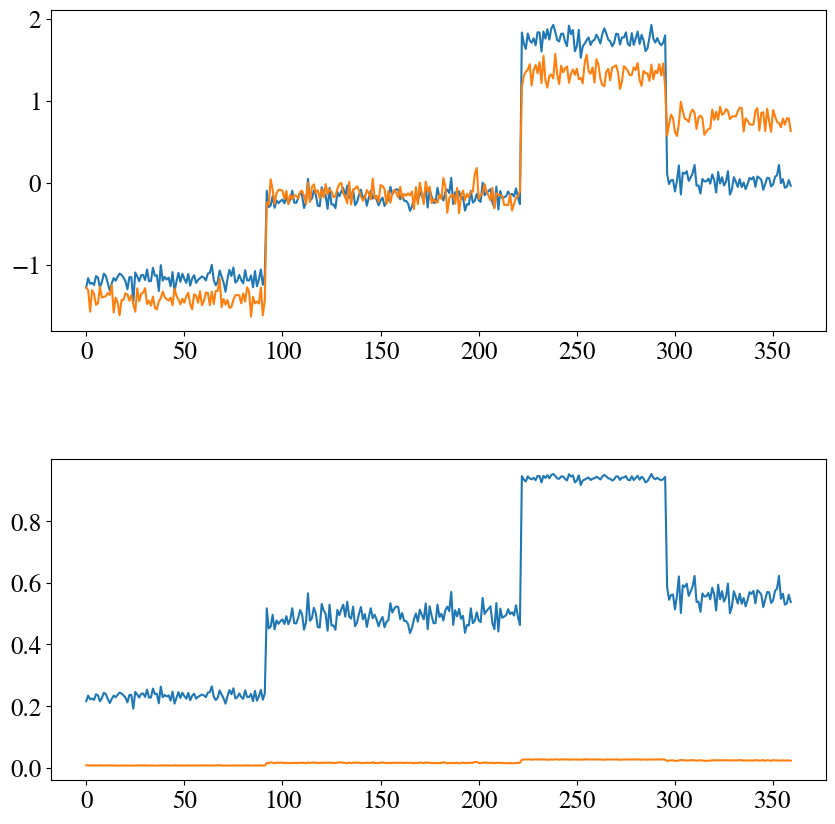

In [25]:
if not RUN_PYTHON_SCRIPT:
    
    data = _get_cpt_ts_wrapper(5, paras_run.n, 3, mean_diff_sd=10).T
    data1 = theta_trans_fn.raw2theta(data)
    plt.figure(figsize=[10, 10])
    plt.subplot(211)
    plt.plot(data[:, 0])
    plt.plot(data[:, 1])
    plt.subplot(212)
    plt.plot(data1[:, 0])
    plt.plot(data1[:, 1])

/mnt/nfs/rad/data/jianglab1/jin/conda/envs/TVSGM/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mnt/nfs/rad/data/jianglab1/jin/conda/envs/TVSGM/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mnt/nfs/rad/data/jianglab1/jin/conda/envs/TVSGM/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mnt/nfs/rad/data/jianglab1/jin/conda/envs/TVSGM/lib/python3.9/site-packages/seaborn/_oldcore.py:111

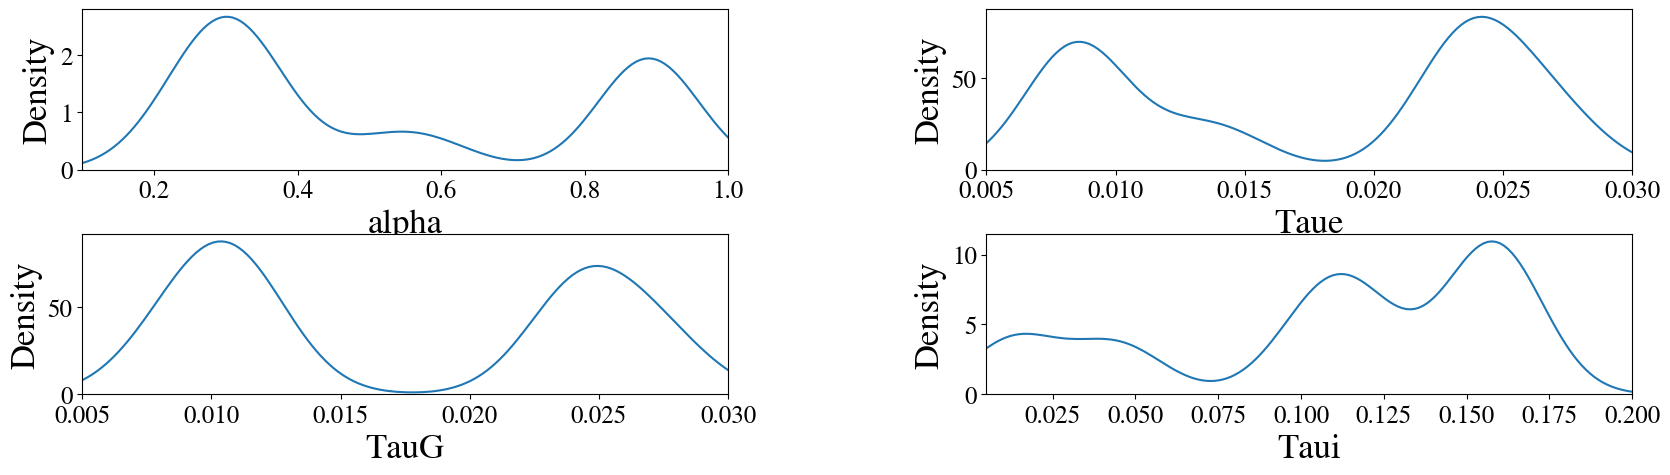

In [26]:
# show demo of generatingt simulation data (Speed is a constant, Mar 30, 2023)
if not RUN_PYTHON_SCRIPT:
    ts_nospeed = _get_cpt_ts_wrapper(4, 1000, ncpt=3).T
    ts_speed = np.repeat(np.random.randn(1), 1000)
    sgm_paramss_raw = np.concatenate([ts_nospeed, ts_speed.reshape(-1, 1)], axis=1)
    sgm_paramss = theta_trans_fn.raw2theta(sgm_paramss_raw)
    
    plt.figure(figsize=[20, 5])
    for ix in range(4):
        plt.subplot(2, 2, ix+1)
        sns.kdeplot(sgm_paramss[:, ix])
        plt.xlim(paras.prior_bds[ix, :])
        plt.xlabel(paras.names[ix])

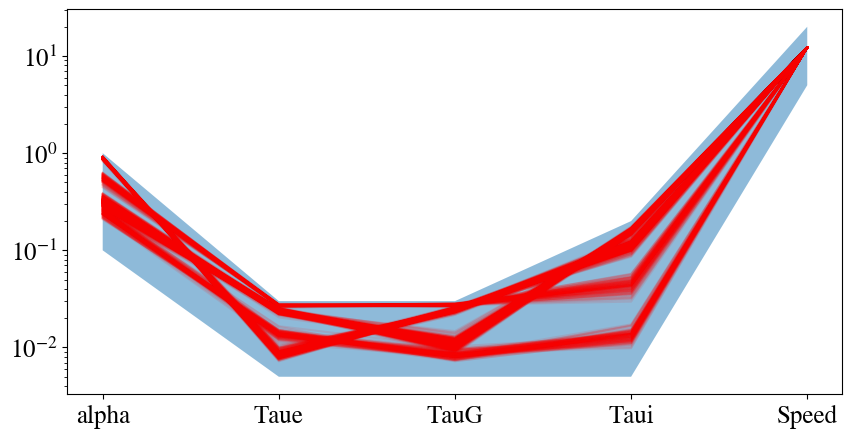

In [27]:
#check the reparameterization
if not RUN_PYTHON_SCRIPT:
    plt.fill_between(np.arange(5), paras.par_low, paras.par_high, alpha=0.5)
    plt.yscale("log")
    for cur_ts_sgm in sgm_paramss:
        plt.plot(np.arange(5), cur_ts_sgm, color="red", alpha=0.1)
    plt.xticks(np.arange(5), paras.names);
    plt.show()
    plt.close()

In [ ]:
# Gerenate data when speed is a constant
sgm_paramsss = []
PSDss = []
for sub_ix in range(paras_run.n_sub):
    ts_dyn = _get_cpt_ts_wrapper(nseq=4, length=paras_run.n, ncpt=3).T
    ts_speed = np.repeat(np.random.randn(1), paras_run.n)
    sgm_paramss_raw = np.concatenate([ts_dyn, ts_speed.reshape(-1, 1)], axis=1)
    
    sgm_paramss = theta_trans_fn.raw2theta(sgm_paramss_raw)
    sgmmodel = SGM(paras.C, paras.D, paras.freqs)
    def _run_fn(cur_sgm):
        sgm_input = edict()
        for ix, name in enumerate(paras.names):
            sgm_input[name] = cur_sgm[ix]
        sgm_input["gei"] = None
        sgm_input["gii"] = None
        cur_PSD = sgmmodel.forward_psd(sgm_input)
        cur_PSD = cur_PSD[:68, :]
        return cur_PSD
    with Parallel(n_jobs=20) as parallel:
        PSDs = parallel(delayed(_run_fn)(cur_sgm) for cur_sgm in tqdm(sgm_paramss, 
                                                                      desc=f"sub {sub_ix+1}/{paras_run.n_sub}", 
                                                                      total=paras_run.n))
    sgm_paramsss.append(sgm_paramss)
    PSDss.append(PSDs)
    
simu_sgm_data = edict()
simu_sgm_data.PSDss = np.array(PSDss)
simu_sgm_data.sgm_paramsss =sgm_paramsss
save_pkl_dict2folder(RES_ROOT/f"simu_cptts_sgm_data_conspeed_nogeigii", simu_sgm_data, is_force=True)

# Train the model

In [2]:
simu_sgm_data = load_pkl_folder2dict(RES_ROOT/"simu_cptts_sgm_data_conspeed_nogeigii");

NameError: name 'load_pkl_folder2dict' is not defined

In [27]:
trained_model = load_pkl_folder2dict(RES_ROOT/"SGM_net", excluding=['opt*']);
sgm_net = trained_model.model
sgm_net.to(dtype=df_dtype);
sgm_net.eval();

Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/SGM_net/freqs.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/SGM_net/loss.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/SGM_net/loss_test.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/SGM_net/model.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/SGM_net/paras.pkl


In [49]:
def _evaluate(all_data):
    num_sub, len_seq, _, _ = all_data.shape
    all_data_raw = torch.tensor(all_data, dtype=df_dtype)
    all_data_input = (all_data_raw - all_data_raw.mean(axis=-1, keepdims=True))/all_data_raw.std(axis=-1, keepdims=True);
    all_data_input = all_data_input.flatten(2);
    
    with torch.no_grad():
        Y_pred, _ = net(all_data_input+pos_enc);
        Y_pred_flt = Y_pred.flatten(0, 1)
        geis = torch.ones(Y_pred_flt.shape[0], 1, dtype=df_dtype, device=Y_pred.device) * 0.3 
        giis = torch.ones(Y_pred_flt.shape[0], 1, dtype=df_dtype, device=Y_pred.device) * 1
        Y_pred_flt_full = torch.cat([
                Y_pred_flt[:, :1], 
                geis, 
                giis, 
                Y_pred_flt[:, 1:],
            ], dim=1)
        X_pred = sgm_net(Y_pred_flt_full);
    corrs = reg_R_fn(all_data_raw.flatten(0, 1), X_pred);
    corrs = corrs.reshape(num_sub, len_seq, -1)
    return corrs.detach().numpy()

In [ ]:
prefix = "GPTnogeigii"

config = edict()
config.nfeature = 39 * 68 # the dim of features at each time point
config.target_dim = 5 # the target dim 
config.ndim = 128 # the output of the first FC layer
config.dropout = 0.0 # the dropout rate
config.n_layer = 4 # the number of self-attention layers
config.n_head = 8 # numher of heads for multi-head attention
config.is_mask = False # Use mask to make the attention causal
config.is_bias = True # Bias  for layernorm
config.block_size = 360 # the preset length of seq, 
config.batch_size = 1 # the batch size
config.k = 1
config.dy_mask = torch.tensor([1, 1, 1, 1, 0], dtype=df_dtype)

pos_enc = generate_position_encode(config.block_size, config.nfeature).unsqueeze(0)

paras_train = edict()
paras_train.niter = 2000
paras_train.loss_out = 1
paras_train.loss_pen_w = 2
paras_train.eval_out = 20
paras_train.clip = 10 # from 
paras_train.lr_step = 100
paras_train.gamma = 0.9 #!!!! 0.5
paras_train.lr = 1e-4 
paras_train.unstable_pen = 10000
paras_train.loss_name = "wmse"


post_fix = "_datataufixed"
stat_part = "_".join(np.array(paras.names)[np.array(config.dy_mask.cpu())==0][:-1])
if len(stat_part) > 0:
    folder_name = f"{prefix}_simu_net_simudatacpt_{paras_train.loss_pen_w*10}_{paras_train.loss_name}_{stat_part}{post_fix}";
else:
    folder_name = f"{prefix}_simu_net_simudatacpt_{paras_train.loss_pen_w*10}_{paras_train.loss_name}{post_fix}";
paras_train.save_dir = RES_ROOT/folder_name
print(paras_train.save_dir)



#  all_data should be num_sub x len_seq x nrois x nfreqs
#  or len_seq x nrois x nfreqs
all_data = simu_sgm_data.PSDss

# to dB
all_data = 20 * np.log10(all_data)

all_data_raw = torch.tensor(all_data, dtype=df_dtype)
all_data_input = (all_data_raw - all_data_raw.mean(axis=-1, keepdims=True))/all_data_raw.std(axis=-1, keepdims=True);
all_data_input = all_data_input.flatten(2);
# input should be num_sub x len_seq unlike lstm

/mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/GPTnogeigii_simu_net_simudatacpt_5.0_wmse_datataufixed


In [52]:
net = myNet(config, 
           prior_bds=torch.tensor(paras.prior_bds, dtype=df_dtype));

net.to(dtype=df_dtype);
if paras_train.loss_name.startswith("corr"):
    loss_fn = reg_R_loss
elif paras_train.loss_name.startswith("linR"):
    loss_fn = lin_R_loss
elif paras_train.loss_name.startswith("wmse"):
    loss_fn = weighted_mse_loss
elif paras_train.loss_name.startswith("mse"):
    loss_fn = nn.MSELoss()
else:
    raise KeyError("No such loss")

optimizer = torch.optim.AdamW(net.parameters(), lr=paras_train.lr, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=paras_train.gamma)

number of parameters: 1.13M


In [53]:
# training
loss_cur = 0
loss_pen_cur = 0
losses = []
losses_pen = []
losses_test = []

t0 = time.time()
sgm_net.eval()
loss_add = 0
for ix in range(paras_train.niter):
    net.train()
    X_seq = all_data_input
    # Zero the gradients
    optimizer.zero_grad()
    
    theta_pred, loss_pen = net(X_seq)
    theta_pred_flt = theta_pred.flatten(0, 1)
    geis = torch.ones(theta_pred_flt.shape[0], 1, dtype=df_dtype, device=theta_pred.device) * 0.3 
    giis = torch.ones(theta_pred_flt.shape[0], 1, dtype=df_dtype, device=theta_pred.device) * 1
    theta_pred_flt_full = torch.cat([
            theta_pred_flt[:, :1], 
            geis, 
            giis, 
            theta_pred_flt[:, 1:],
        ], dim=1)
    loss_pen = loss_pen[net.config.dy_mask==1].mean()
    X_pred = sgm_net(theta_pred_flt_full)
    #X_pred = sgm_net(theta_pred.flatten(0, 1))
    loss_main = loss_fn(X_seq.flatten(0, 1).reshape(-1, 68, len(paras.freqs)),
                   X_pred)
    if paras_train.unstable_pen > 0:
        unstable_inds = paras_stable_check(theta_pred_flt_full.detach().numpy());
        unstable_inds = torch.tensor(unstable_inds).reshape(*theta_pred.shape[:2])
        loss_add = (paras_train.unstable_pen * unstable_inds.unsqueeze(-1) * theta_pred).mean();
    loss = loss_main + loss_add + paras_train.loss_pen_w * loss_pen
    
    # Perform backward pass
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(net.parameters(), paras_train.clip)
    # Perform optimization
    optimizer.step()
    
    if ix % paras_train.lr_step == (paras_train.lr_step-1):
        scheduler.step()
        print("Learning rate is",scheduler.get_last_lr())
    
    loss_cur = loss_cur + loss_main.item()
    loss_pen_cur = loss_pen_cur + loss_pen.item()
    if ix % paras_train.loss_out == (paras_train.loss_out-1):
        losses.append(loss_cur/paras_train.loss_out)
        losses_pen.append(loss_pen_cur/paras_train.loss_out)
        print(f"At iter {ix+1}/{paras_train.niter}, "
              f"the losses are {loss_cur/paras_train.loss_out:.5f} (train). "
              f"the pen losses are {loss_pen_cur/paras_train.loss_out:.5f} (train). "
              f"The time used is {delta_time(t0):.3f}s. "
             )
        loss_cur = 0
        loss_pen_cur = 0
        t0 = time.time()
        
    if ix % paras_train.eval_out == (paras_train.eval_out-1):
        net.eval()
        loss_test = _evaluate(all_data).mean()
        losses_test.append(loss_test)
        print(f"="*100)
        print(f"At iter {ix+1}/{paras_train.niter}, "
              f"the losses on all data are {loss_test:.5f}. "
              f"The time used is {delta_time(t0):.3f}s. "
             )
        print(f"="*100)
        t0 = time.time()
    


At iter 1/2000, the losses are 1.56138 (train). the pen losses are 0.01170 (train). The time used is 2.657s. 
At iter 2/2000, the losses are 1.44553 (train). the pen losses are 0.01411 (train). The time used is 2.542s. 
At iter 3/2000, the losses are 1.24386 (train). the pen losses are 0.01719 (train). The time used is 2.535s. 
At iter 4/2000, the losses are 1.05260 (train). the pen losses are 0.01972 (train). The time used is 2.546s. 
At iter 5/2000, the losses are 0.98891 (train). the pen losses are 0.02197 (train). The time used is 2.531s. 
At iter 6/2000, the losses are 0.97979 (train). the pen losses are 0.02398 (train). The time used is 2.540s. 
At iter 7/2000, the losses are 0.96475 (train). the pen losses are 0.02602 (train). The time used is 2.519s. 
At iter 8/2000, the losses are 0.91802 (train). the pen losses are 0.02811 (train). The time used is 2.516s. 
At iter 9/2000, the losses are 0.84569 (train). the pen losses are 0.03027 (train). The time used is 2.537s. 
At iter 10

KeyboardInterrupt: 

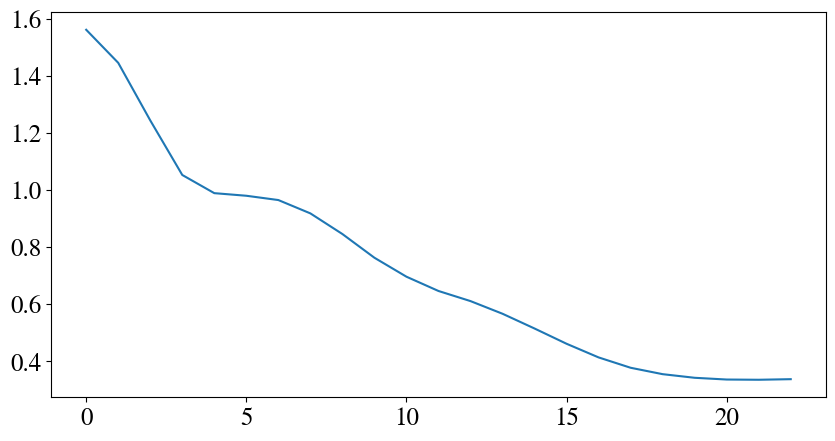

In [54]:
plt.plot(losses)
#plt.yscale("log")

In [55]:
net.eval()
with torch.no_grad():
    Y_pred, _ = net(all_data_input)
sgm_paramss_est = Y_pred.cpu().numpy();

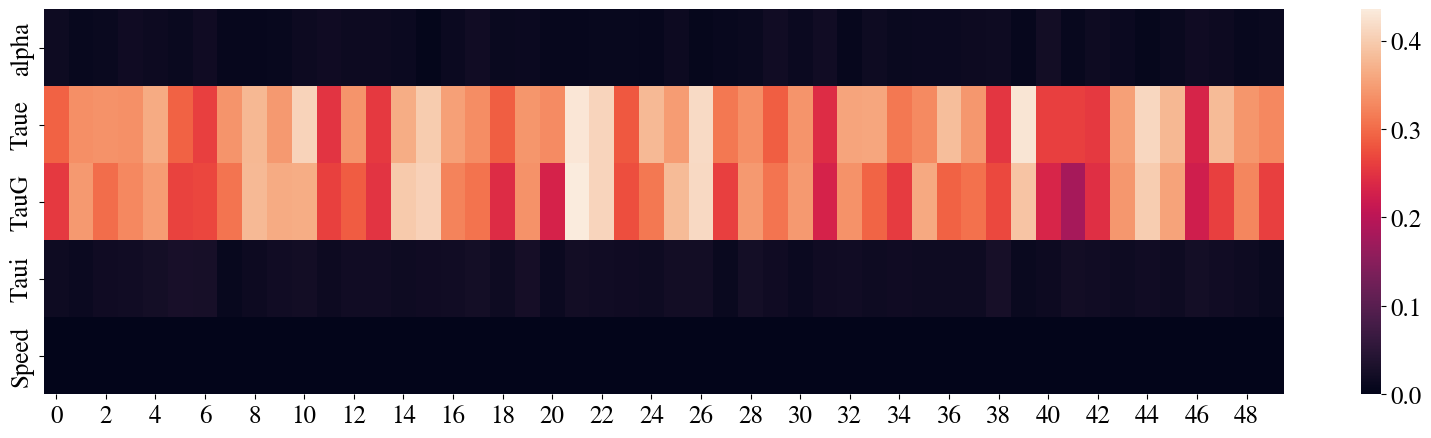

In [56]:
pred_params = sgm_paramss_est[:, :]
CVs = pred_params.std(axis=1)/pred_params.mean(axis=1)
plt.figure(figsize=[20, 5])
sns.heatmap(CVs.T, annot=False)
plt.yticks(np.arange(len(paras.names))+0.5, paras.names);

In [57]:
np.median(CVs, axis=0)

array([1.1997375e-02, 3.3917409e-01, 3.0856168e-01, 1.8254267e-02,
       1.6394902e-06], dtype=float32)

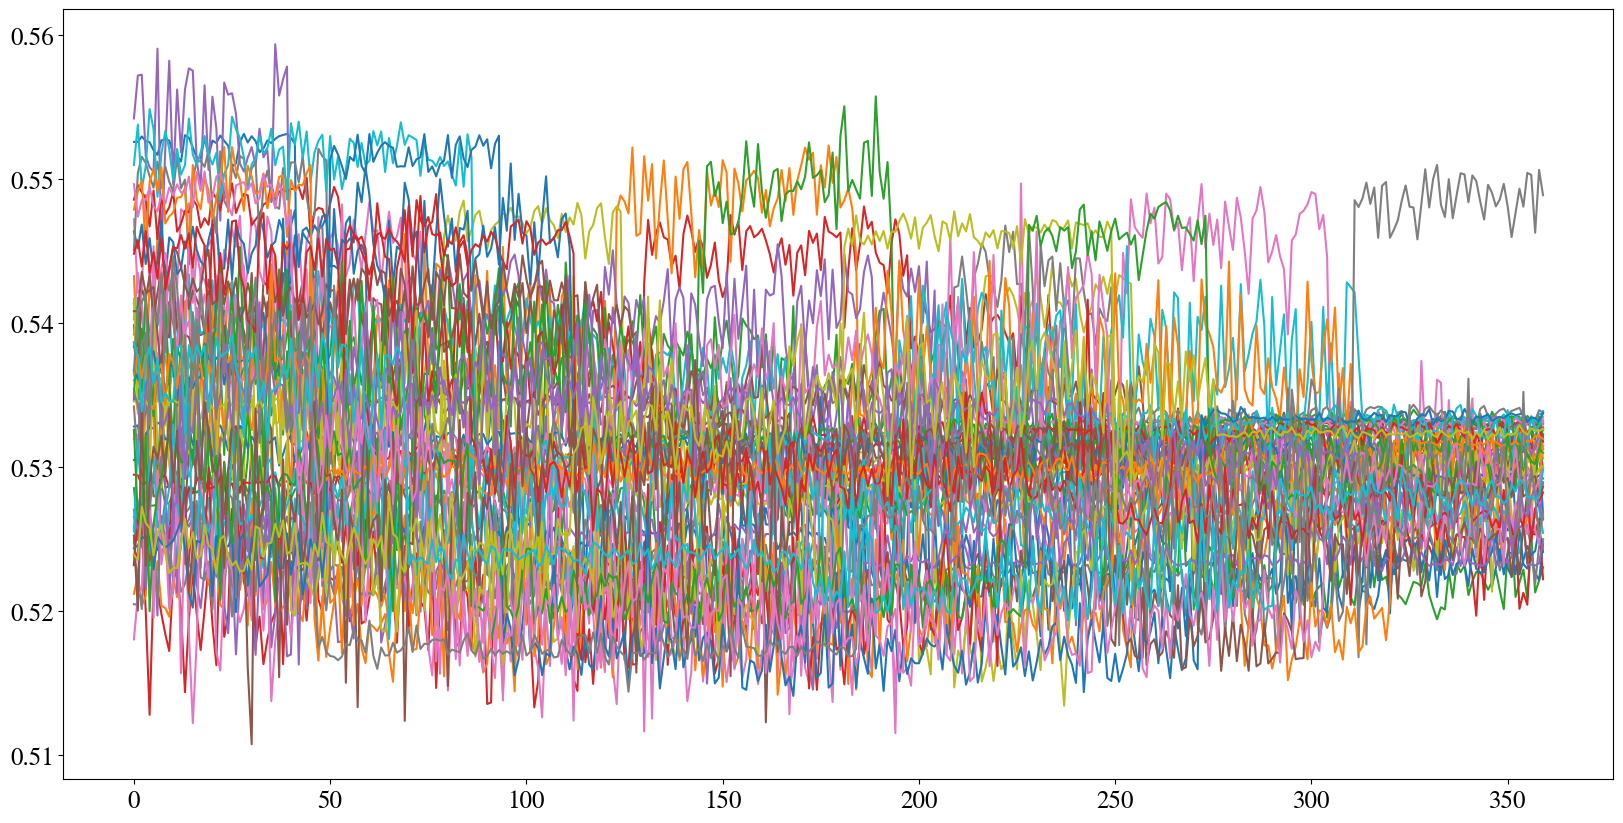

In [58]:
para_ix = 0
plt.figure(figsize=[20, 10])
for sub_ix in range(pred_params.shape[0]):
    plt.plot(pred_params[sub_ix, :, para_ix])

In [59]:
if (paras_train.save_dir).exists():
    trained_model = load_pkl_folder2dict(paras_train.save_dir)
else:
    trained_model = edict()
    trained_model.model = net
    trained_model.loss_fn = loss_fn
    trained_model.optimizer = optimizer
    trained_model.paras = paras_train
    trained_model.config = config
    trained_model.loss = losses
    save_pkl_dict2folder(paras_train.save_dir, trained_model, is_force=True)

Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/GPTnogeigii_simu_net_simudatacpt_5.0_wmse_datataufixed/config.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/GPTnogeigii_simu_net_simudatacpt_5.0_wmse_datataufixed/loss.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/GPTnogeigii_simu_net_simudatacpt_5.0_wmse_datataufixed/loss_fn.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/GPTnogeigii_simu_net_simudatacpt_5.0_wmse_datataufixed/model.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/GPTnogeigii_simu_net_simudatacpt_5.0_wmse_datataufixed/optimizer.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/GPTnogeigii_simu_net_simudatacpt_5.0_wmse_datataufixed/paras.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/GPTnogeigii_simu_net_simudatacpt_5.0_

In [60]:
trained_model.model.eval()
with torch.no_grad():
    Y_pred, _ = trained_model.model(all_data_input)
sgm_paramss_est = Y_pred.cpu().numpy()
trained_model.sgm_paramss_est = sgm_paramss_est
save_pkl_dict2folder(paras_train.save_dir, trained_model, is_force=True)

Save to /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/GPTnogeigii_simu_net_simudatacpt_5.0_wmse_datataufixed/config.pkl
Save to /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/GPTnogeigii_simu_net_simudatacpt_5.0_wmse_datataufixed/loss.pkl
Save to /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/GPTnogeigii_simu_net_simudatacpt_5.0_wmse_datataufixed/loss_fn.pkl
Save to /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/GPTnogeigii_simu_net_simudatacpt_5.0_wmse_datataufixed/model.pkl
Save to /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/GPTnogeigii_simu_net_simudatacpt_5.0_wmse_datataufixed/optimizer.pkl
Save to /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/GPTnogeigii_simu_net_simudatacpt_5.0_wmse_datataufixed/paras.pkl
Save to /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/GPTnogeigii_simu_net_simudatacpt_5.0_wmse_datataufi

# Evaluate

## SGM parameters

In [13]:
#save_dir = paras_train.save_dir
save_dir = RES_ROOT/"GPTnogeigii_larger_simu_net_simudatacpt_10_wmse_datataufixed"
trained_model = load_pkl_folder2dict(save_dir);
simu_sgm_data = load_pkl_folder2dict(RES_ROOT/"simu_cptts_sgm_data_conspeed_nogeigii");

Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/GPTnogeigii_larger_simu_net_simudatacpt_10_wmse_datataufixed/config.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/GPTnogeigii_larger_simu_net_simudatacpt_10_wmse_datataufixed/loss.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/GPTnogeigii_larger_simu_net_simudatacpt_10_wmse_datataufixed/loss_fn.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/GPTnogeigii_larger_simu_net_simudatacpt_10_wmse_datataufixed/model.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/GPTnogeigii_larger_simu_net_simudatacpt_10_wmse_datataufixed/optimizer.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/GPTnogeigii_larger_simu_net_simudatacpt_10_wmse_datataufixed/paras.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/G

In [14]:
true_params = np.array(simu_sgm_data.sgm_paramsss)
pred_params = trained_model.sgm_paramss_est;

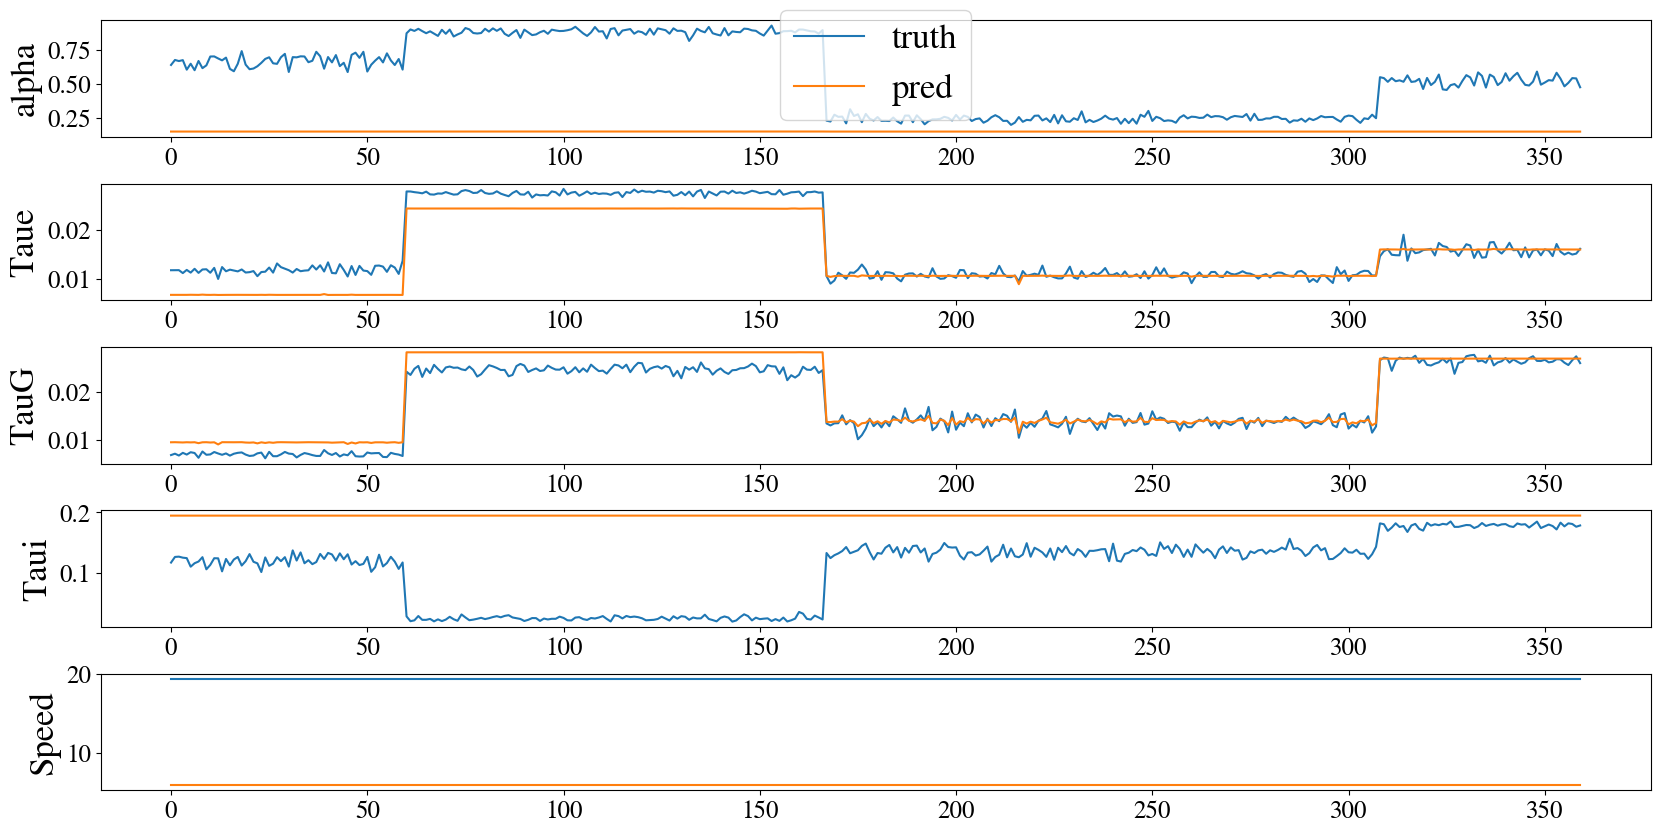

In [15]:
sub_ix = 10
fig, axs = plt.subplots(len(paras.names), 1, figsize=[20, 10])
for para_ix in range(len(paras.names)):
    axs[para_ix].plot(true_params[sub_ix, :, para_ix], label="truth")
    axs[para_ix].plot(pred_params[sub_ix, :, para_ix], label="pred")
    axs[para_ix].set_ylabel(f"{paras.names[para_ix]}")
    if para_ix == 0:
        axs[para_ix].legend()

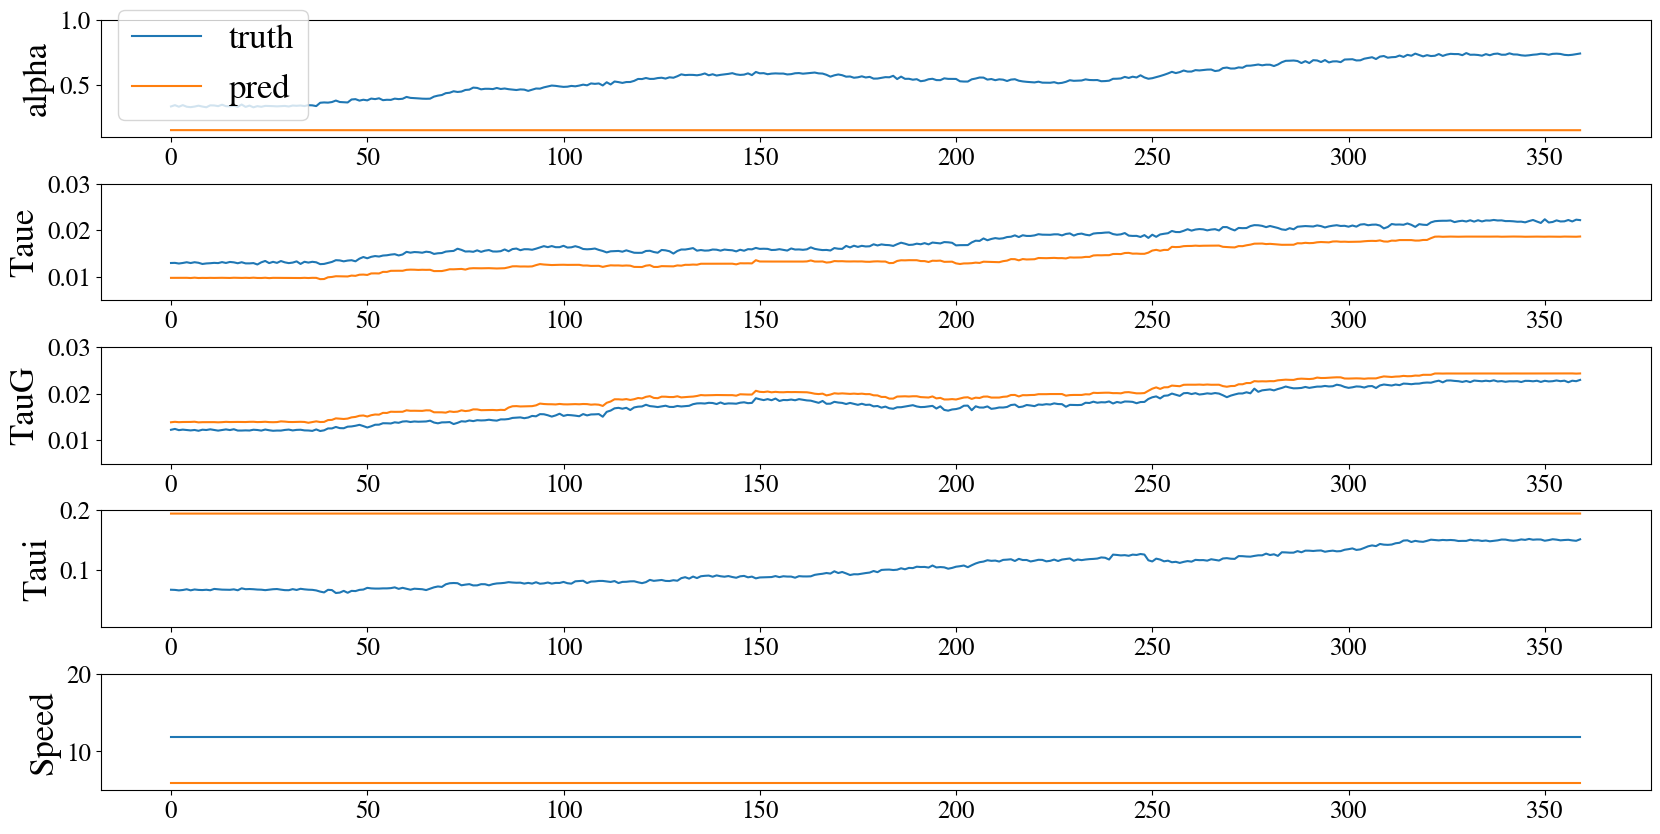

In [16]:
fig, axs = plt.subplots(len(paras.names), 1, figsize=[20, 10])
for para_ix in range(len(paras.names)):
    axs[para_ix].plot(true_params[..., para_ix].mean(axis=0), label="truth")
    axs[para_ix].plot(pred_params[..., para_ix].mean(axis=0), label="pred")
    axs[para_ix].set_ylabel(f"{paras.names[para_ix]}")
    axs[para_ix].set_ylim(paras.prior_bds[para_ix, :])
    if para_ix == 0:
        axs[para_ix].legend()

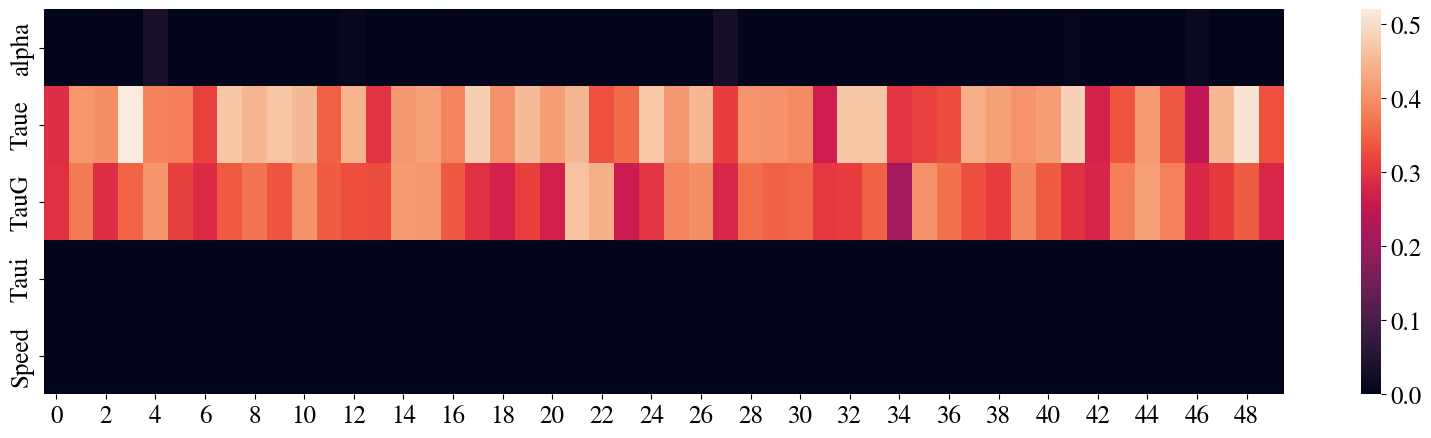

In [17]:
CVs = pred_params.std(axis=1)/pred_params.mean(axis=1)
plt.figure(figsize=[20, 5])
sns.heatmap(CVs.T, annot=False)
plt.yticks(np.arange(len(paras.names))+0.5, paras.names);

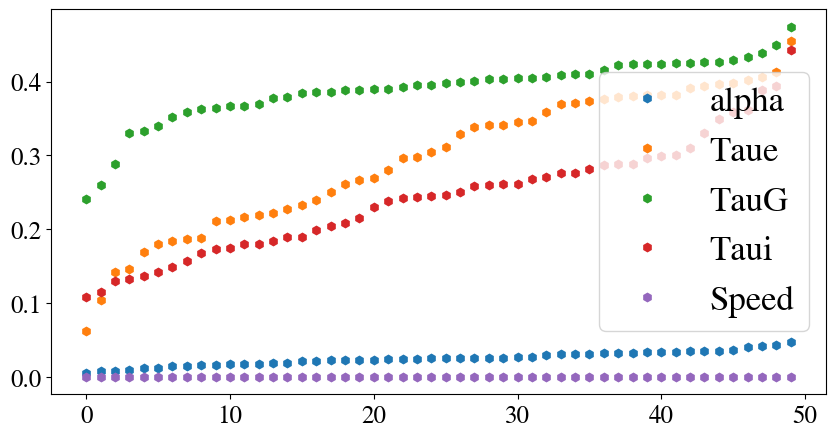

In [19]:
plt.figure(figsize=[10, 5])
for para_ix in range(5):
    plt.plot(np.sort(CVs[:, para_ix]), "h", label=f"{paras.names[para_ix]}")
plt.legend()

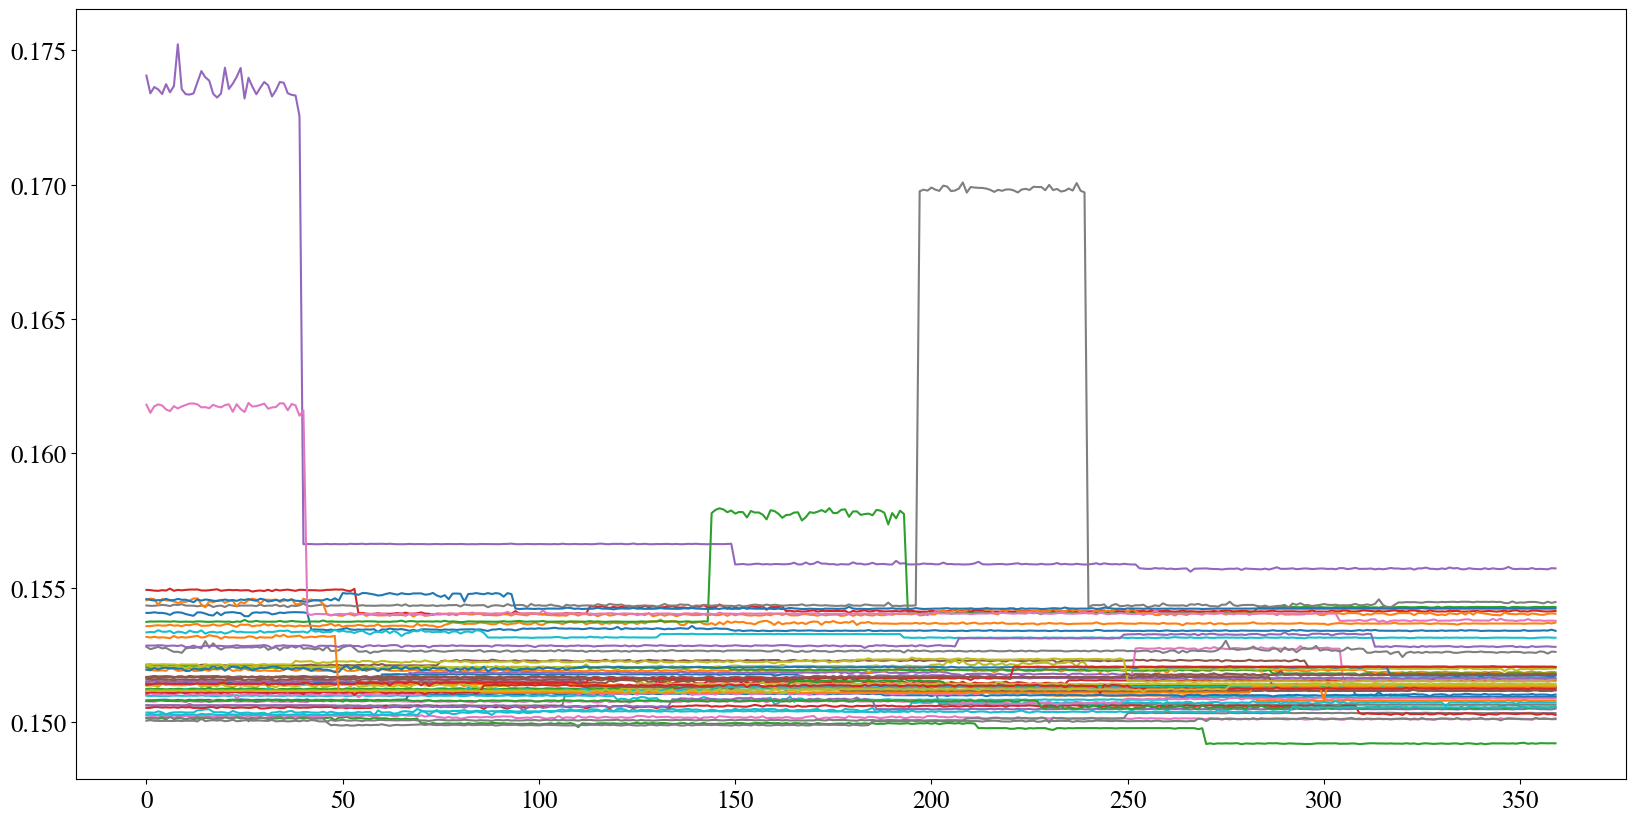

In [18]:
para_ix = 0
plt.figure(figsize=[20, 10])
for sub_ix in range(pred_params.shape[0]):
    plt.plot(pred_params[sub_ix, :, para_ix])

### Can recover truth?

In [19]:
dy_mask = np.array(trained_model.config.dy_mask);

In [20]:
# not need speed
true_params_flt = true_params[:, :, dy_mask==1].transpose(0, 2, 1).reshape(-1, true_params.shape[1])
pred_params_flt = pred_params[:, :, dy_mask==1].transpose(0, 2, 1).reshape(-1, pred_params.shape[1]);
true_params_stat = true_params[:, 0, dy_mask==0]
pred_params_stat = pred_params[:, 0, dy_mask==0]
dyn_names = np.array(paras.names)[dy_mask==1]
stat_names = np.array(paras.names)[dy_mask==0]
num_dyn_params = (dy_mask==1).sum();

#### Static

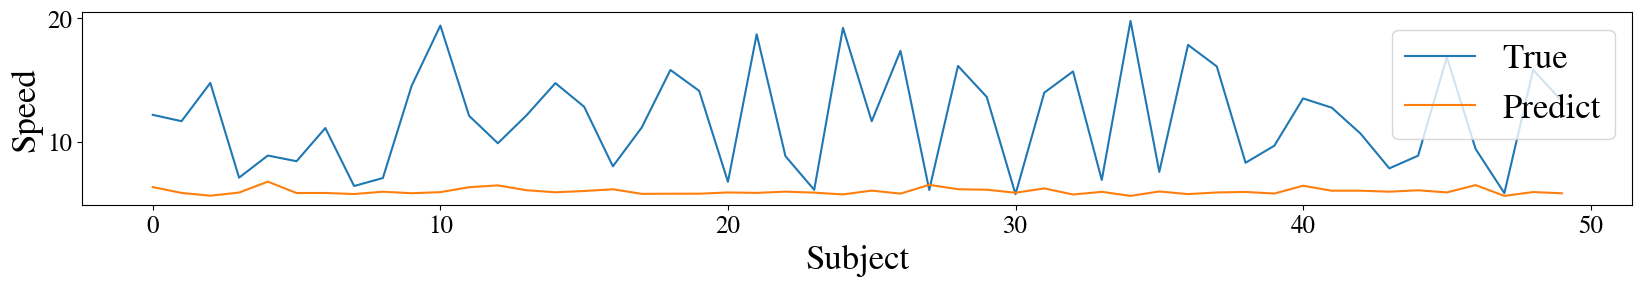

In [21]:
plt.figure(figsize=[20, 2.5*len(stat_names)])
for para_ix in range(len(stat_names)):
    plt.subplot(len(stat_names), 1, para_ix+1)
    plt.plot(true_params_stat[:, para_ix], label="True")
    plt.plot(pred_params_stat[:, para_ix], label="Predict")
    plt.xlabel("Subject")
    plt.ylabel(stat_names[para_ix])
    plt.legend()

#### Reg R

In [22]:

corrs = reg_R_fn(true_params_flt, pred_params_flt).reshape(-1, num_dyn_params);
corrs1, pvals = [], []
for ix in range(true_params_flt.shape[0]):
    rv, pval = scipy.stats.pearsonr(true_params_flt[ix, :], pred_params_flt[ix, :])
    corrs1.append(rv)
    pvals.append(pval)
corrs1 = np.array(corrs1).reshape(-1, num_dyn_params)
pvals = np.array(pvals).reshape(-1, num_dyn_params);

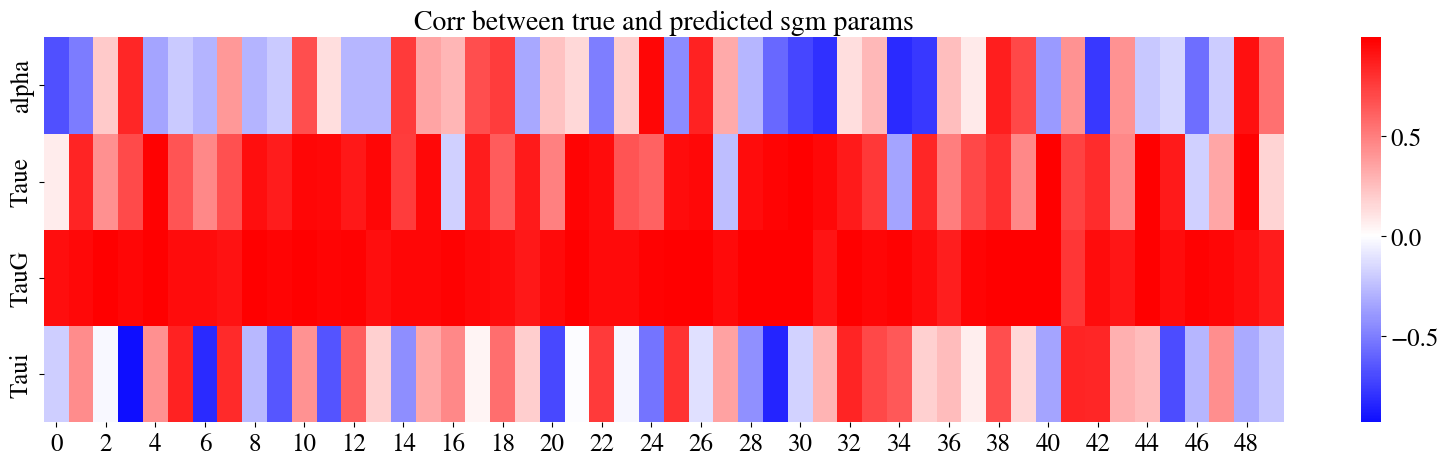

In [23]:
plt.figure(figsize=[20, 5])
plt.title(f"Corr between true and predicted sgm params", fontsize=20)
sns.heatmap(corrs.T, cmap="bwr", center=0)
plt.yticks(np.arange(num_dyn_params)+0.5, dyn_names);

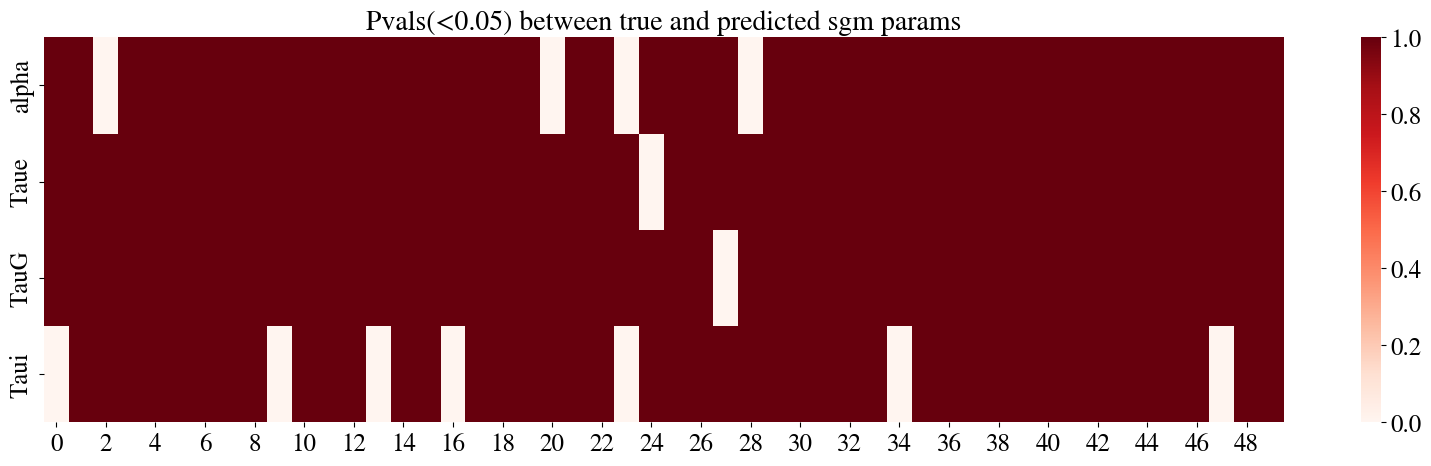

In [88]:
plt.figure(figsize=[20, 5])
plt.title(f"Pvals(<0.05) between true and predicted sgm params", fontsize=20)
sns.heatmap(pvals.T<0.05, cmap="Reds", vmin=0)
plt.yticks(np.arange(num_dyn_params)+0.5, dyn_names);

#### MSE

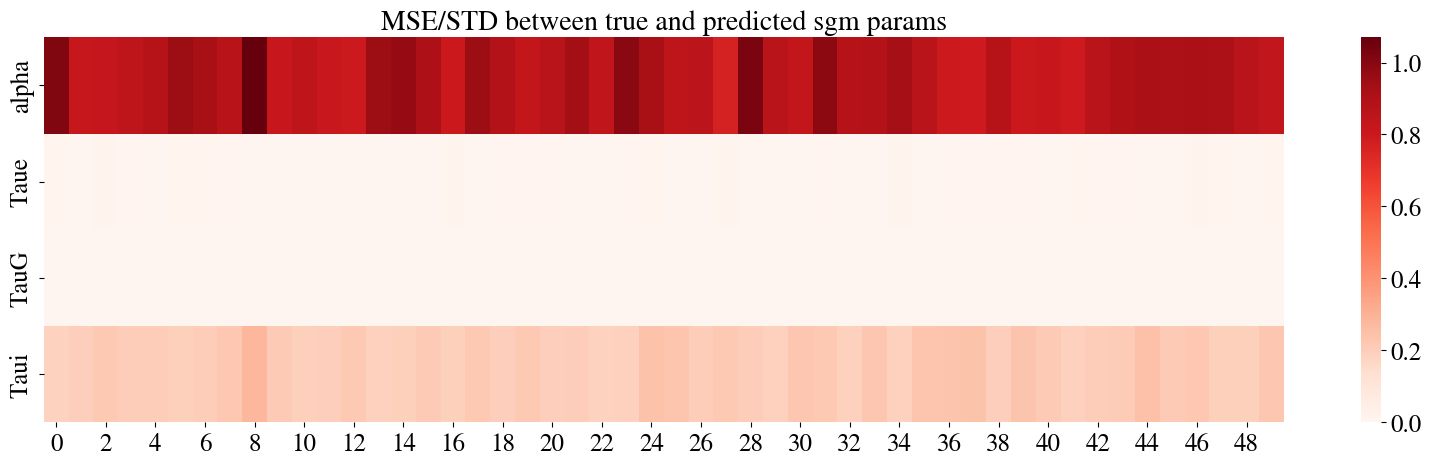

In [24]:
mses = np.mean((true_params_flt - pred_params_flt)**2, axis=1).reshape(-1, num_dyn_params);
stds = true_params_flt.std(axis=1).reshape(-1, num_dyn_params)

plt.figure(figsize=[20, 5])
plt.title(f"MSE/STD between true and predicted sgm params", fontsize=20)
sns.heatmap((mses/stds).T, cmap="Reds", vmin=0, annot=False)
plt.yticks(np.arange(num_dyn_params)+0.5, dyn_names);

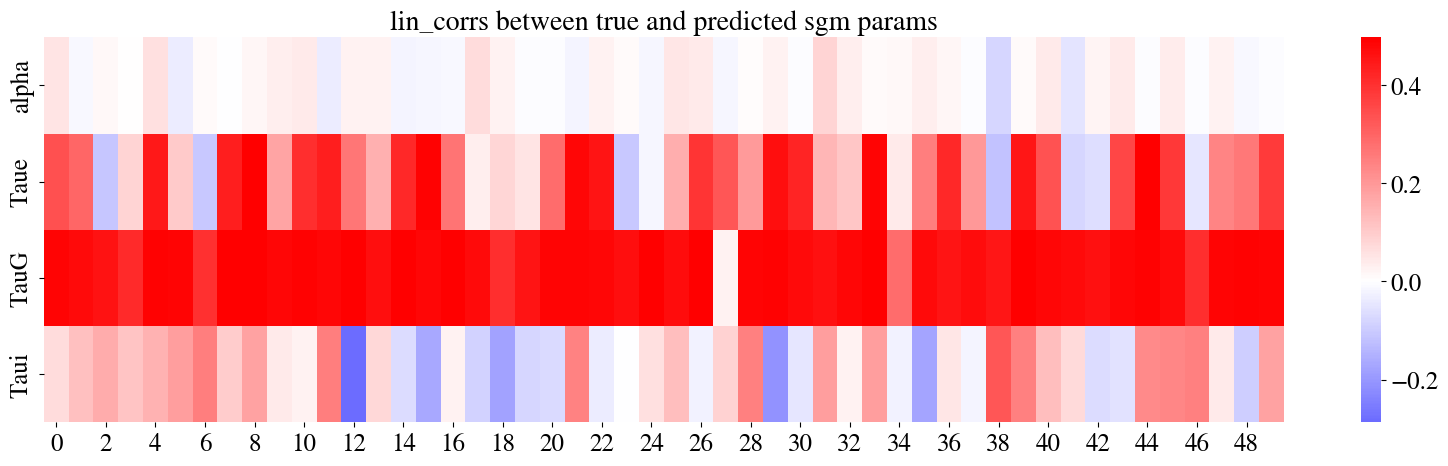

In [27]:
lin_corrs = lin_R_fn(true_params_flt, pred_params_flt).reshape(-1, num_dyn_params);

plt.figure(figsize=[20, 5])
plt.title(f"lin_corrs between true and predicted sgm params", fontsize=20)
sns.heatmap(lin_corrs.T, cmap="bwr", center=0, annot=False)
plt.yticks(np.arange(num_dyn_params)+0.5, dyn_names);

### Corr between SGM params

In [28]:
corr_mats_pred = np.array([np.corrcoef(pred_params[0, :, dy_mask==1]) for sub_ix in range(pred_params.shape[0])]);
corr_mats_true = np.array([np.corrcoef(true_params[0, :, dy_mask==1]) for sub_ix in range(true_params.shape[0])]);

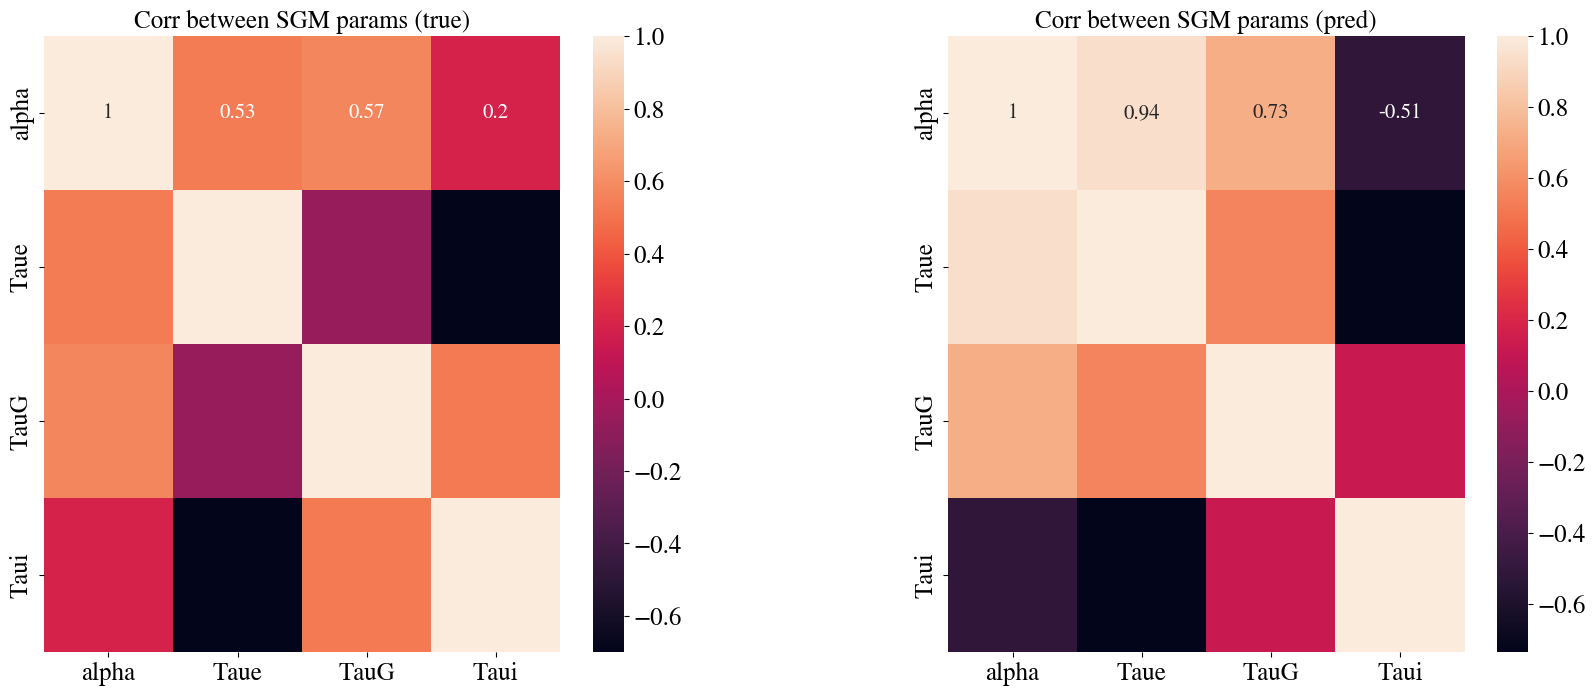

In [29]:
plt.figure(figsize=[20,8])
plt.subplot(121)
plt.title("Corr between SGM params (true)")
sns.heatmap(np.mean(corr_mats_true, axis=0), annot=True, annot_kws={"fontsize":15})
plt.yticks(np.arange(num_dyn_params)+0.5, dyn_names);
plt.xticks(np.arange(num_dyn_params)+0.5, dyn_names);
plt.subplot(122)
plt.title("Corr between SGM params (pred)")
sns.heatmap(np.mean(corr_mats_pred, axis=0), annot=True, annot_kws={"fontsize":15})
plt.yticks(np.arange(num_dyn_params)+0.5, dyn_names);
plt.xticks(np.arange(num_dyn_params)+0.5, dyn_names);

In [33]:
def _addgeigii(Y_pred):
    geis = torch.ones(*Y_pred.shape[:-1], 1, dtype=df_dtype, device=Y_pred.device) * 0.3 
    giis = torch.ones(*Y_pred.shape[:-1], 1, dtype=df_dtype, device=Y_pred.device) * 1
    Y_pred_full = torch.cat([
                Y_pred[..., :1], 
                geis, 
                giis, 
                Y_pred[..., 1:],
            ], dim=-1)
    return Y_pred_full

### Recontruct PSD

In [34]:
pred_params.shape

(50, 360, 5)

In [60]:
sgm_net.eval()
with torch.no_grad():
    Y_pred_full = _addgeigii(torch.tensor(pred_params))
    X_rec1 = sgm_net(Y_pred_full)
X_rec1 = X_rec1.numpy()
sgm_est = pred_params.reshape(-1, 5)

# wrong way to reshape
#X_org = 20* np.log10(simu_sgm_data.PSDss.reshape(68, -1, len(paras.freqs)).transpose(1, 0, 2))
# correct way to reshape
X_org = 20* np.log10(simu_sgm_data.PSDss.reshape(-1, 68, len(paras.freqs)))
sgm_org = np.array(simu_sgm_data.sgm_paramsss).reshape(-1, 5)

X_org = (X_org- X_org.mean(axis=-1, keepdims=1))/X_org.std(axis=-1, keepdims=1);

In [61]:
sgm_est.shape

(18000, 5)

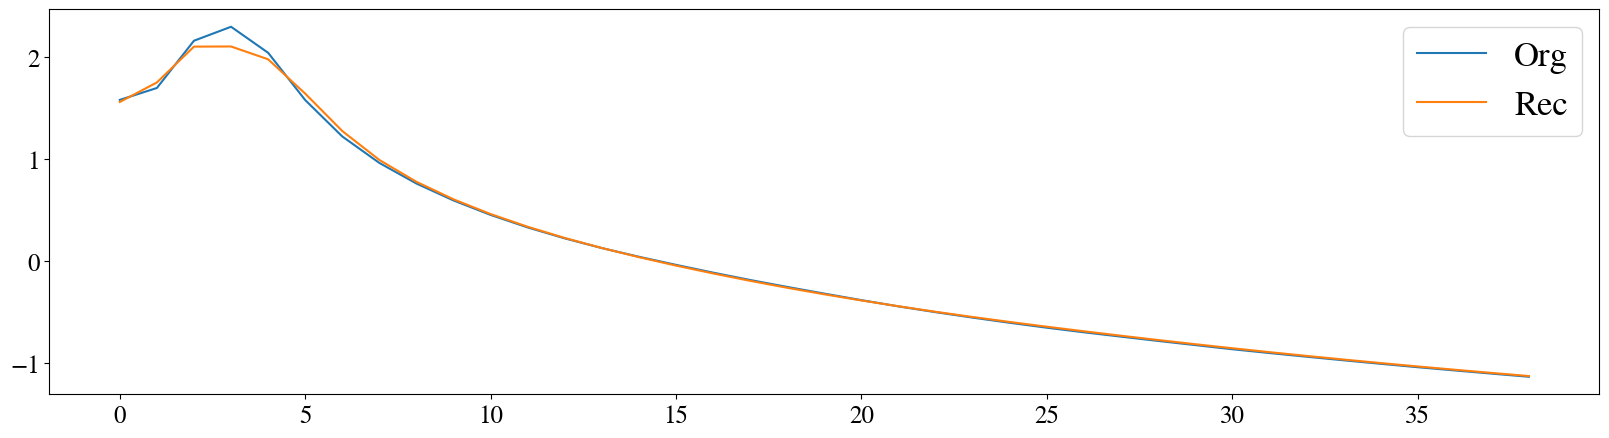

In [77]:
sub_idx = 200

cur_org = X_org[sub_idx, :, :]
cur_rec = X_rec1[sub_idx, :, :]

roi_ix = 0
plt.figure(figsize=[20, 5])
plt.plot(cur_org[:, :].mean(axis=0), label="Org")
plt.plot(cur_rec[:, :].mean(axis=0), label="Rec")
plt.legend()


In [78]:
import pandas as pd
df = pd.DataFrame({
    "org": sgm_est[sub_idx, :],
    "rec": sgm_org[sub_idx],
})
df.index = paras.names
df

,org,rec
alpha,0.153414,0.727418
Taue,0.016914,0.017777
TauG,0.023941,0.023533
Taui,0.194310,0.147563
Speed,6.314918,12.168995
